In [1]:
import pandas as pd
import plotly.express as px
import wmfdata as wmf

In [2]:
wmf.utils.insert_code_toggle()

In [5]:
# Used to remove partial results for the latest day
TODAY = "20221012"

story_edit = wmf.mariadb.run(f"""
    WITH story_page AS (
        SELECT 
            page_id,
            page_title
        FROM page
        WHERE
            page_namespace = 1704
    ),
    story_edit AS (
        SELECT
            rev_timestamp AS dt,
            rev_id AS rev_id,
            actor_name AS user_name,
            REPLACE(page_title, '_', ' ') AS story_title,
            IF(rev_parent_id = 0, 'create new story', 'edit existing story') AS edit_type,
            'live' AS page_status
        FROM story_page
        LEFT JOIN revision
        ON page_id = rev_page
        LEFT JOIN actor
        ON rev_actor = actor_id
        
        UNION
        
        SELECT
            ar_timestamp AS dt,
            ar_rev_id AS rev_id,
            actor_name AS user_name,
            REPLACE(ar_title, '_', ' ') AS story_title,
            IF(ar_parent_id = 0, 'create new story', 'edit existing story') AS edit_type,
            'deleted' AS page_status
        FROM archive
        LEFT JOIN actor
        ON ar_actor = actor_id
        WHERE
            ar_namespace = 1704
            
    ),
    story_user AS (
        SELECT
            user_name,
            min(rev_id) AS first_story_edit
        FROM story_edit
        GROUP BY user_name
    )
    SELECT 
        dt,
        rev_id,
        se.user_name,
        story_title,
        edit_type,
        rev_id = first_story_edit AS is_user_first_edit,
        page_status
    FROM story_edit se
    LEFT JOIN story_user su
    ON se.user_name = su.user_name
    WHERE
        -- For some reason, there is a single story revision from January
        dt >= '20220630'
        AND dt < '{TODAY}'
    """,
    "idwiki",
    date_col="dt"
).assign(
    is_user_first_edit=lambda df: df["is_user_first_edit"].astype(bool)
)

In [6]:
story_edit

,dt,rev_id,user_name,story_title,edit_type,is_user_first_edit,page_status
0,2022-10-07 15:51:29,21759948,Triwahyuni.o,10 Museum di Sumatera Barat,create new story,False,live
1,2022-10-08 16:51:58,21763542,Hernawanwan,3 Museum di Sleman yang Wajib Kamu Kunjungi,create new story,False,live
2,2022-09-24 05:08:58,21698598,Mechaenjoyed,5G Technology,create new story,True,live
3,2022-10-05 22:26:58,21754202,Hernawanwan,7 Rekomendasi Museum di Jawa Tengah,create new story,False,live
4,2022-10-06 22:57:55,21757532,Hernawanwan,8 Alasan Kenapa Kamu Wajib ke Museum Monumen B...,create new story,False,live
...,...,...,...,...,...,...,...
893,2022-07-05 18:31:54,21337552,Bennylin,Sejarah pers di Surakarta (Bagian 2/3),create new story,False,deleted
894,2022-07-05 18:33:21,21337564,Bennylin,Sejarah pers di Surakarta (Bagian 2/3),edit existing story,False,deleted
895,2022-07-05 18:34:07,21337570,Bennylin,Sejarah pers di Surakarta (Bagian 2/3),edit existing story,False,deleted
896,2022-09-12 13:07:40,21648836,Tamu002,Sekilas Museum Balla Lompoa,create new story,False,deleted


In [12]:
daily_edit = (
    story_edit.groupby([
        pd.Grouper(key="dt", freq="D"),
        "edit_type"
    ]).aggregate(
        edits=("dt", len)
    ).reset_index()
    .sort_values(
        by=["dt", "edit_type"],
        ignore_index=True
    )
)

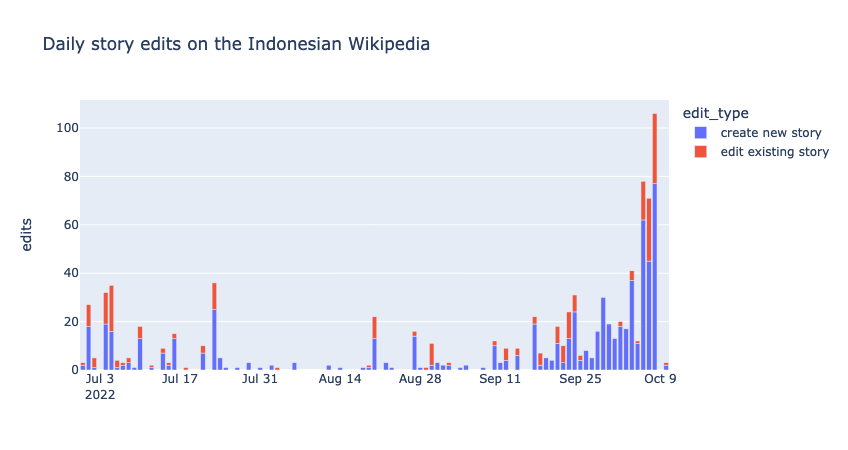

In [13]:
fig = px.bar(
    daily_edit,
    x="dt",
    y="edits",
    color="edit_type",
    title="Daily story edits on the Indonesian Wikipedia",
    labels={
        "dt": "",
    },
    height=450
)

fig.show()

In [14]:
def classify_editor(df):
    if df["is_user_first_edit"].any():
        return "new story editor"
    else:
        return "repeat story editor"
    
daily_editor = (
    story_edit.groupby([
        pd.Grouper(key="dt", freq="D"),
        "user_name"
    ]).apply(classify_editor).reset_index()
    .rename(columns={0: "editor_class"})
    .groupby([
        "dt",
        "editor_class"
    ]).agg(editors=("user_name", len))
    .reset_index()
)

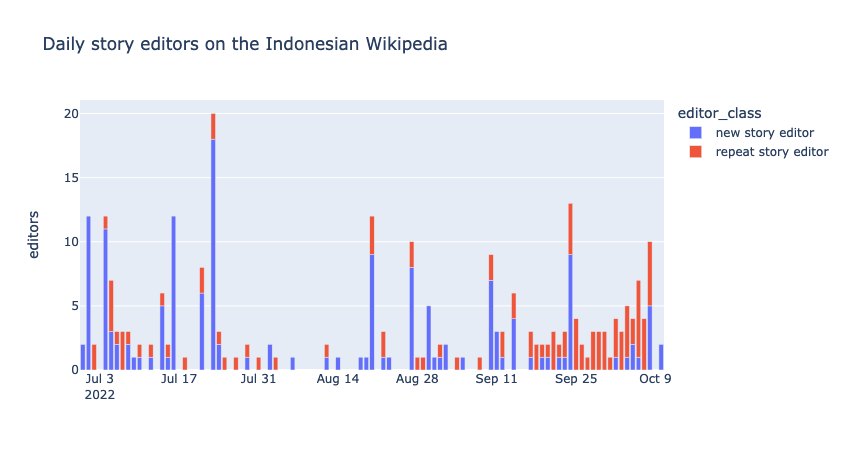

In [15]:
fig = px.bar(
    daily_editor,
    x="dt",
    y="editors",
    color="editor_class",
    title="Daily story editors on the Indonesian Wikipedia",
    labels={
        "dt": "",
    },
    height=450
)

fig.show()

# Generate editors list

In [37]:
def unique_days(s):
    return s.dt.round(freq="D").nunique()

def stories_created(df):
    return df.query("edit_type == 'create new story'")["story_title"].nunique()
    

agg_1 = (
    story_edit
    .groupby("user_name")
    .agg(
        days_active=("dt", unique_days),
        story_edits=("dt", len),
        stories_created_or_edited=("story_title", "nunique")
    )
)

agg_2 = (
    story_edit
    .groupby("user_name")
    .apply(stories_created)
    .rename("stories_created")
)

story_user = agg_1.join(agg_2).sort_values("days_active", ascending=False)

In [40]:
story_user.to_csv("data/story_users.csv")